In [ ]:
import csv
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random

from scipy.special import logsumexp  # to deal with potential overflow issues


def set_seed(seed):  # For reproducibility, fix random seeds.
  random.seed(seed)
  np.random.seed(seed)

set_seed(42)

# Fashion MNIST

Download the Fashion MNIST dataset from [here](https://drive.google.com/drive/folders/1BnU7wVriolasZAZ1bSDTyll1Tp61hP1c?usp=sharing). It consists of 16 x 16 grayscale images (downsized from 28 x 28 for efficiency), split into 50,000 training and 10,000 validation images. Each image is labeled as one of 10 clothing categories (e.g., dress, sandal, shirt). We will assume that we have the directory `data/FashionMNIST/` in our Google Drive account. Let's load the data and stare at it.  

In [ ]:
# Load the Drive helper and mount. You will have to authorize this operation. 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
datadir = '/content/drive/My Drive/data/FashionMNIST/'
label_names = ['tshirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']  # Hardcoded

class FashionMNIST:

  def __init__(self, split):
    assert split in ['Tr', 'Vl']  # We don't have a test set
    self.inputs = np.load('{:s}x{:s}.npy'.format(datadir, split))  # (N, 16^2)
    self.labels = np.load('{:s}y{:s}.npy'.format(datadir, split))  # (N, 10)
    self.num_examples, self.dim = self.inputs.shape
    self.num_labels = self.labels.shape[1]
    # Partition data by labels
    self.partition = [self.inputs[np.where(np.argmax(self.labels, axis=1) == y)[0]] for y in range(self.num_labels)]

In [ ]:
data_train = FashionMNIST('Tr')
data_val = FashionMNIST('Vl')

print(data_train.inputs.shape, data_val.inputs.shape)


(50000, 256) (10000, 256)


In [ ]:
def show_image(image, ax=None):
  width = int(np.sqrt(image.shape[0]))
  image = image.reshape(width, width)  
  if ax == None:
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
  imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
  imgplot.set_interpolation('nearest')
  ax.xaxis.set_ticks_position('top')
  ax.yaxis.set_ticks_position('left')
  plt.axis('off')

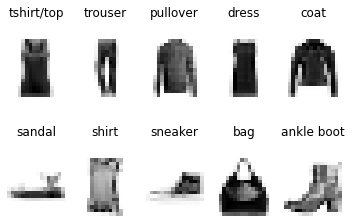

In [ ]:
for y in range(10):
  ax = plt.subplot(2, 5, y + 1)
  ax.clear()
  show_image(data_train.partition[y][0], ax)
  ax.set_title(label_names[y])

The images are a little blurry because we downsized them, but they will do. 

# Gaussian Mixture Model (GMM)

A **Gaussian mixture model** (GMM) with $K$ components has learnable parameters $\pi \in \mathbb{R}^K$ and $\mu_k \in \mathbb{R}^K, \Sigma_k \in \mathbb{R}^{K \times K}$ for each $k = 1 \ldots K$, where it is always assumed that 

- $\pi$ is a (full-support) distribution over the $K$ components. So $\pi_k > 0$ and $\sum_{k=1}^K \pi_k = 1$. 
- $\Sigma_k$ is a symmetric and positive definite (thus invertible) for each $k$. 

A GMM  defines a joint distribution over $k \in \{1 \ldots K\}$ and $x \in \mathbb{R}^d$ by 
$$
p(k,x) = \pi_k \times \mathcal{N}(\mu_k, \Sigma_k)(x)
$$
where $\mathcal{N}(\mu_k, \Sigma_k)(x)$ is the probability of $x$ under the Gaussian distribution with mean $\mu_k$ and covariance matrix $\Sigma_k$. For practical reasons, we do the following:  

- We optionally restrict ourselves to *diagonal* covariance matrices to make calculation simpler and more efficient.
- We work in *log space* for numerical stability, that is: $\log p(k,x) = \log \pi_k + \log \mathcal{N}(\mu_k, \Sigma_k)(x)$. 
- We make all variables multidimensional tensors so that we can use linear algebraic operations instead of for loops. 

In [ ]:
class GMM:

  def __init__(self, dim, num_components, diag=False):
    self.pi = np.full(num_components, 1. / num_components)  # (K,)
    self.mu = np.zeros((num_components, dim))  # (K, d)
    if diag:
      self.sigma = np.ones((num_components, dim))  # (K, d)
    else:   
      self.sigma = np.array([np.identity(dim) for _ in range(num_components)])   # (K, d, d)
    self.diag = diag

  def compute_log_probs(self, inputs):  # (N, d)
    log_pi = np.log(self.pi)[:, np.newaxis]  # (K, 1)
    diffs = inputs[np.newaxis, :, :] - self.mu[:, np.newaxis, :]  # (K, N, d)

    # TODO: implement, do not use for loops
    log_probs = None  # (K, N): log p(k, inputs[i])

    if self.diag:
      det_sigma = np.sum(np.log(self.sigma),axis = 1)
      det_sigma = det_sigma[:, np.newaxis]
      inv_sigma = 1 / self.sigma
      matrix  = np.apply_along_axis(np.diag, -1, inv_sigma) 
      distance = (-1/2)*np.einsum('KNd, Kdd, KdN->KN',np.transpose(diffs, (0,1,2)),matrix,np.swapaxes(diffs,1,2))
      consts = self.mu.shape[1]*np.log(2*np.pi)
      prob = -consts/2 - det_sigma/2 + distance
      log_probs = log_pi + prob
    else:
      inv_sigma = np.linalg.inv(self.sigma)
      det_sigma = np.linalg.slogdet(self.sigma)[1][:, np.newaxis]
      distance = (-1/2)*np.einsum('KNd, Kdd, KdN->KN',np.transpose(diffs, (0,1,2)),inv_sigma,np.swapaxes(diffs, 1,2))
      consts = self.mu.shape[1]*np.log(2*np.pi)
      prob = -consts/2 - det_sigma/2 + distance
      log_probs = log_pi + prob

    return log_probs  

  def compute_posteriors(self, inputs):  # (N, d)
    log_probs = self.compute_log_probs(inputs)  # (K, N): log p(k, x)
    marginal_log_probs = logsumexp(log_probs, axis=0)  # (N,): log p(x)
    marginal_log_likelihood = marginal_log_probs.mean()  # Scalar
    posteriors = np.exp(log_probs - marginal_log_probs[np.newaxis, :])  # (K, N): p(k|x)
    return posteriors, marginal_log_likelihood, marginal_log_probs

In [ ]:
import unittest

from scipy.stats import multivariate_normal 

class TestGMM(unittest.TestCase):
      
  def setUp(self):
    set_seed(42)
    self.dim = 100
    self.num_components = 7
    self.num_examples = 200
    self.power = 2 # Check for numerical stability

    self.inputs = np.random.randn(self.num_examples, self.dim)

  def test_model_diag(self): 
    model = self.init_model(diag=True)
    log_probs_gold = self.get_log_probs_gold(model)
    log_probs = model.compute_log_probs(self.inputs)
    for k in range(self.num_components):
      for i in range(self.num_examples):
        self.assertAlmostEqual(log_probs[k, i], log_probs_gold[k, i])

  def test_model_nondiag(self): 
    model = self.init_model(diag=False)
    log_probs_gold = self.get_log_probs_gold(model)
    log_probs = model.compute_log_probs(self.inputs)
    for k in range(self.num_components):
      for i in range(self.num_examples):
        self.assertAlmostEqual(log_probs[k, i], log_probs_gold[k, i])

  def get_log_probs_gold(self, model):
    log_probs_gold = []
    for k in range(self.num_components):
      dist = multivariate_normal(mean=model.mu[k], cov=(np.diag(model.sigma[k]) if model.diag else model.sigma[k]))
      log_probs_gold.append([np.log(model.pi[k]) + dist.logpdf(self.inputs[i]) for i in range(self.num_examples)])
    return np.array(log_probs_gold)

  def init_model(self, diag=False):
    model = GMM(self.dim, self.num_components, diag=diag)
    pi_unnormalized = np.random.uniform(size=(self.num_components,)) ** self.power
    model.pi = pi_unnormalized / pi_unnormalized.sum()
    model.mu = np.random.randn(self.num_components, self.dim) ** self.power 
    if diag:
      model.sigma = np.random.randn(self.num_components, self.dim) ** self.power
    else:
      model.sigma = np.array([np.diag(np.random.randn(self.dim)) ** self.power for _ in range(self.num_components)])
    return model
            
unittest.main(TestGMM(), argv=[''], verbosity=2, exit=False)

test_model_diag (__main__.TestGMM) ... ok
test_model_nondiag (__main__.TestGMM) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.199s

OK


# Expectation Maximization (EM)

The EM algorithm trains a GMM on *unlabeled* data by alternating the E step and the M step:
- E step: Compute posteriors $p(k|x_i)$ for every training input $i = 1 \ldots N$ and label $k = 1\ldots K$. This needs an initial set of parameter values.
- M step: Calculate the maximum-likelihood estimate of parameters under the posteriors.


In [ ]:
class GMMTrainerEM:

  def __init__(self, model, smoothing=0.1):
    self.model = model
    self.smoothing = smoothing
    self.diag_smoother =  smoothing * np.array([np.identity(model.mu.shape[1]) for _ in range(model.mu.shape[0])])

  def train(self, inputs, num_iterations_max=40, verbose=False, init_method='naive'):
    self.init_centers(inputs, init_method=init_method)
    mll_previous = -np.inf 
    posteriors, mll, _ = self.model.compute_posteriors(inputs)  # E step
    for iteration in range(num_iterations_max): 
      self.update_parameters(inputs, posteriors)  # M step
      posteriors, mll, _ = self.model.compute_posteriors(inputs)  # E step
      if verbose:
        print('Iteration {:3d}:\t marginal log-likelihood {:10.4f}'.format(iteration + 1,  mll))
      if np.isclose(mll, mll_previous):
        break
      mll_previous = mll
    return mll, iteration

  def update_parameters(self, inputs, posteriors):
    expected_counts = posteriors.sum(axis=1) + self.smoothing # (K,)
    self.model.pi = expected_counts / expected_counts.sum()

    weighted_sums = posteriors @ inputs  # (K, d)
    self.model.mu = weighted_sums / expected_counts[:, np.newaxis]

    diffs = inputs[np.newaxis, :, :] - self.model.mu[:, np.newaxis, :]  # (K, N, d)
    diffs_weighted = posteriors[:, :, np.newaxis] * diffs  # (K, N, d)
    if self.model.diag:
      self.model.sigma = np.sum(diffs_weighted*diffs, axis = 1)  # TODO: Implement
      self.model.sigma = self.model.sigma / expected_counts[:, np.newaxis] + self.smoothing 
    else:
      self.model.sigma = logsumexp(np.einsum("KdN, KNd -> Kd", diffs_weighted.transpose((0,2,1)), diffs))  # TODO: Implement
      self.model.sigma = (self.model.sigma)/expected_counts[:, np.newaxis, np.newaxis] + self.diag_smoother
      

  def init_centers(self, inputs, init_method='naive'):
    # Find K centers from the given input vectors (N, d) somehow.
    if init_method == 'naive':

      # TODO: Implement
      
      # Tip: try selecting a random input as the first center, then iteratively selecting argmax_i sum_{l<k} ||x_l - x_i||
      idx = np.random.randint(inputs.shape[0])
      self.model.mu = np.zeros((self.model.mu.shape[0], inputs.shape[1]))
      # print('inp[idx]: ', inputs[idx])
      self.model.mu[0] = inputs[idx]
      inputs = np.delete(inputs, idx, 0)

      for i in range(1, self.model.mu.shape[0]):
        dist = {}

        for j in range(i):
          # norm = np.einsum("ij, ij -> i", (self.model.mu[j] - inputs), inputs)
          norm = np.linalg.norm(self.model.mu[j] - inputs)
          temp = np.max(norm)
          index = np.argmax(norm)
          dist[temp] = index
        
        index = dist[max(dist.keys())]
        self.model.mu[i] = inputs[index]
        inputs = np.delete(inputs, index, 0)

    else: 
      raise ValueError('Unknown init method: ' + init_method)

# Experiments with Diagonal GMMs

We can use GMMs for classification, by training a GMM for each input partition with the same label then at test time predicting the label corresponding to the GMM with highest *marginal* likelihood.

In [ ]:
def compute_accuracy(models, data):  # models[y]: GMM for label y
  log_probs_all = np.zeros((data.num_examples, data.num_labels))
  for y in range(data.num_labels):
    log_probs_all[:, y] = np.max(models[y].compute_log_probs(data.inputs), axis = 0)  # TODO: Implement
  preds = np.argmax(log_probs_all, axis=1)
  acc = np.mean(preds == np.argmax(data.labels, axis=1)) * 100.
  return acc, preds

One cool thing is that each mean $\mu_k$ corresponding to component $k$ can be visualized. We will hypothesize that different components learn different representations of the same label.

In [ ]:
def show_means(models, y):
  num_components = len(models[y].pi)
  fig, axes = plt.subplots(1, num_components)

  for k in range(num_components):
    if num_components == 1:
      ax = axes
    else:
      ax = axes[k]
    show_image(models[y].mu[k], ax)
    ax.axis("off")
    if k == 0:
      ax.set_title(label_names[y] + "/" + str(k))
    else:
      ax.set_title("/" + str(k))
  return fig, axes

We're ready to train diagonal GMMs with various $K$ values. The training is pretty sensitive to the smoothing parameter so be careful. 

***Training a diagonal GMM with K=1 components***
Label 0:  1 iterations, final MLL    -18.360
Label 1:  1 iterations, final MLL     13.110
Label 2:  1 iterations, final MLL    -27.079
Label 3:  1 iterations, final MLL     -3.922
Label 4:  1 iterations, final MLL    -16.957
Label 5:  1 iterations, final MLL    -10.366
Label 6:  1 iterations, final MLL    -30.040
Label 7:  1 iterations, final MLL     15.278
Label 8:  1 iterations, final MLL    -48.372
Label 9:  1 iterations, final MLL    -13.003
K=1: acc train 65.01, acc val 64.29


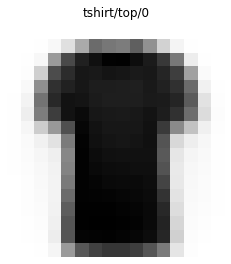

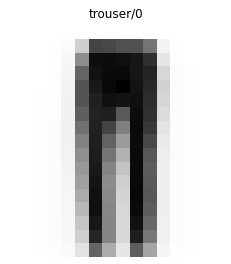

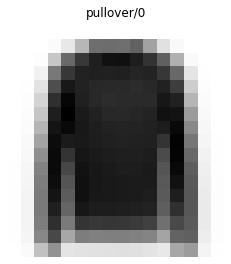

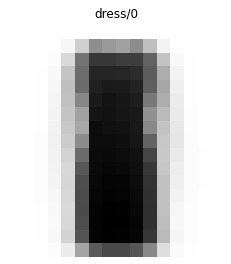

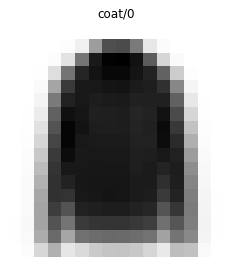

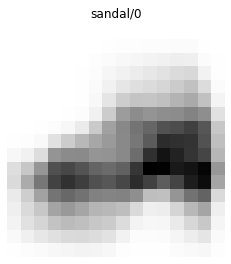

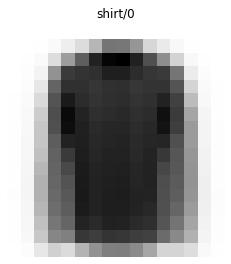

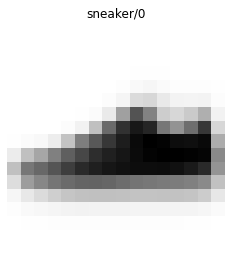

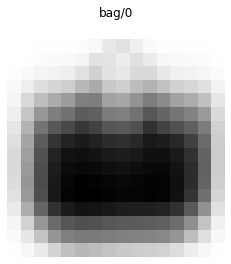

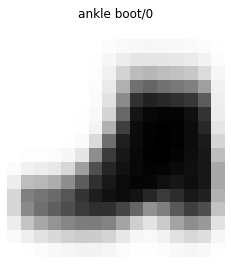

***Training a diagonal GMM with K=3 components***
Label 0: 39 iterations, final MLL      8.287
Label 1: 31 iterations, final MLL     24.300
Label 2: 31 iterations, final MLL      4.003
Label 3: 29 iterations, final MLL     13.943
Label 4: 28 iterations, final MLL      7.669
Label 5: 39 iterations, final MLL      2.123
Label 6: 10 iterations, final MLL      2.574
Label 7: 16 iterations, final MLL     25.866
Label 8: 39 iterations, final MLL    -17.718
Label 9: 25 iterations, final MLL      7.215
K=3: acc train 71.21, acc val 70.92


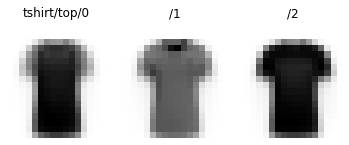

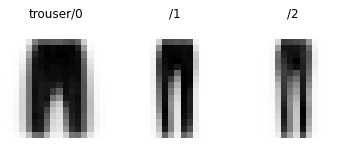

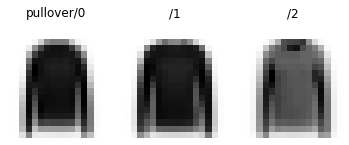

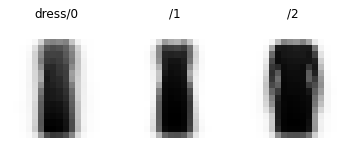

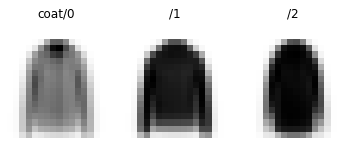

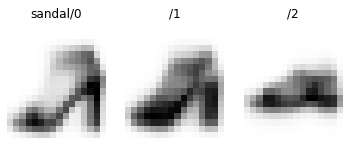

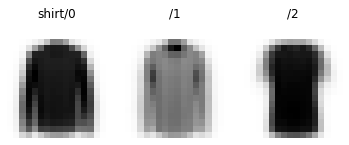

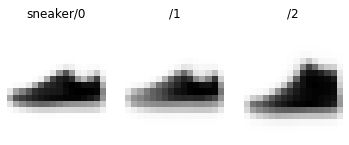

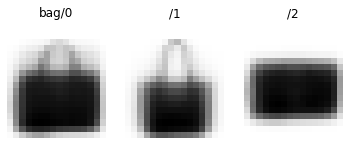

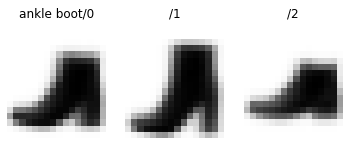

***Training a diagonal GMM with K=5 components***
Label 0: 17 iterations, final MLL     14.460
Label 1: 15 iterations, final MLL     28.372
Label 2: 18 iterations, final MLL      8.429
Label 3: 18 iterations, final MLL     17.665
Label 4: 39 iterations, final MLL     13.483
Label 5: 39 iterations, final MLL      5.861
Label 6: 39 iterations, final MLL      9.202
Label 7: 19 iterations, final MLL     29.251
Label 8: 39 iterations, final MLL     -9.977
Label 9: 39 iterations, final MLL     11.614
K=5: acc train 71.39, acc val 70.57


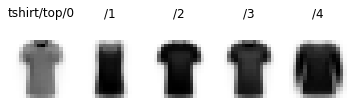

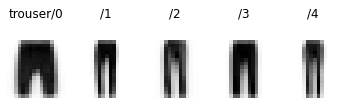

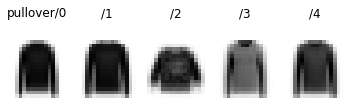

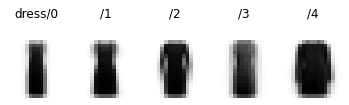

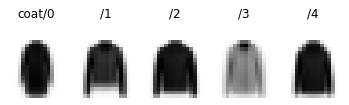

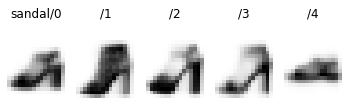

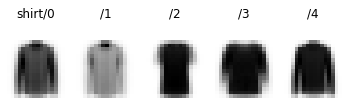

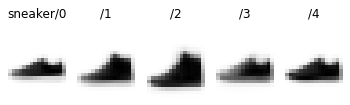

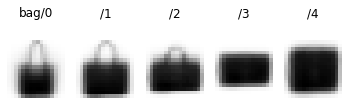

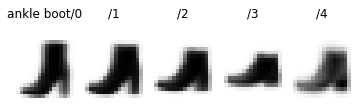

***Training a diagonal GMM with K=7 components***
Label 0: 20 iterations, final MLL     15.759
Label 1: 39 iterations, final MLL     30.205
Label 2: 39 iterations, final MLL     13.286
Label 3: 39 iterations, final MLL     19.868
Label 4: 39 iterations, final MLL     16.677
Label 5: 39 iterations, final MLL      8.330
Label 6: 39 iterations, final MLL     11.517
Label 7: 39 iterations, final MLL     30.181
Label 8: 39 iterations, final MLL     -2.519
Label 9: 39 iterations, final MLL     14.399
K=7: acc train 74.15, acc val 73.45


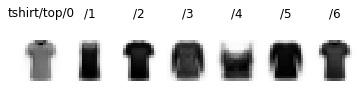

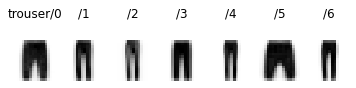

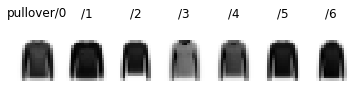

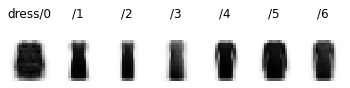

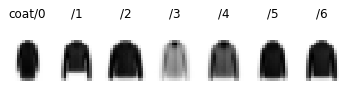

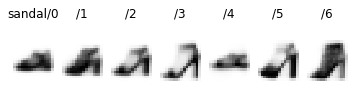

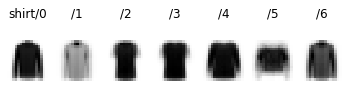

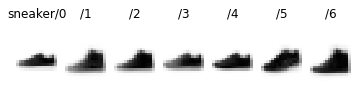

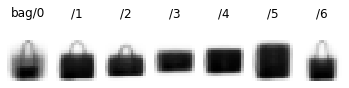

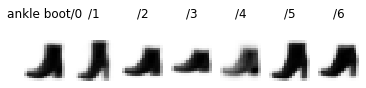

***Training a diagonal GMM with K=9 components***
Label 0: 39 iterations, final MLL     17.921
Label 1: 28 iterations, final MLL     32.111
Label 2: 39 iterations, final MLL     14.637
Label 3: 39 iterations, final MLL     21.097
Label 4: 39 iterations, final MLL     18.045
Label 5: 39 iterations, final MLL      9.259
Label 6: 39 iterations, final MLL     13.181
Label 7: 21 iterations, final MLL     31.289
Label 8: 39 iterations, final MLL      0.309
Label 9: 39 iterations, final MLL     17.199
K=9: acc train 74.08, acc val 73.23


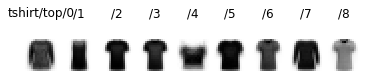

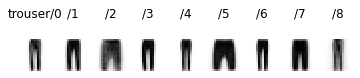

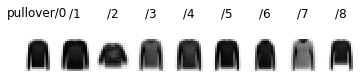

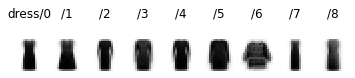

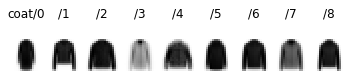

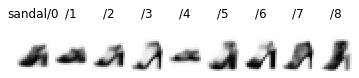

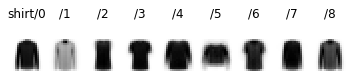

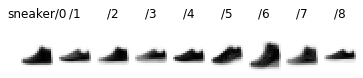

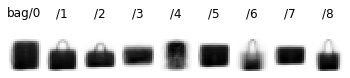

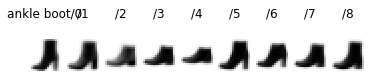

***Training a diagonal GMM with K=11 components***
Label 0: 39 iterations, final MLL     18.902
Label 1:  6 iterations, final MLL     32.957
Label 2: 20 iterations, final MLL     16.041
Label 3: 39 iterations, final MLL     22.279
Label 4: 14 iterations, final MLL     19.743
Label 5: 39 iterations, final MLL     10.881
Label 6: 31 iterations, final MLL     14.562
Label 7: 39 iterations, final MLL     31.871
Label 8: 39 iterations, final MLL      2.298
Label 9: 39 iterations, final MLL     18.248
K=11: acc train 75.96, acc val 74.94


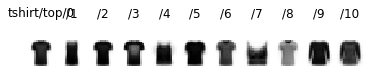

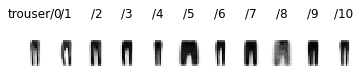

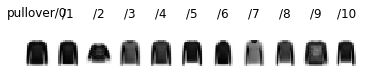

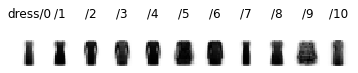

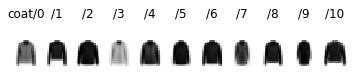

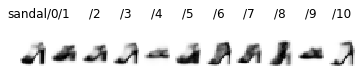

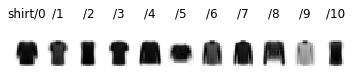

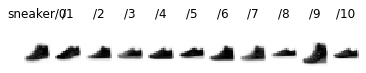

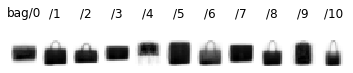

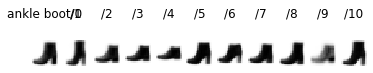

***Training a diagonal GMM with K=13 components***
Label 0: 33 iterations, final MLL     19.400
Label 1: 39 iterations, final MLL     33.531
Label 2: 39 iterations, final MLL     17.110
Label 3: 39 iterations, final MLL     23.464
Label 4: 23 iterations, final MLL     20.922
Label 5: 39 iterations, final MLL     11.891
Label 6: 17 iterations, final MLL     16.370
Label 7: 39 iterations, final MLL     32.456
Label 8: 39 iterations, final MLL      4.358
Label 9: 39 iterations, final MLL     19.091
K=13: acc train 76.21, acc val 75.14


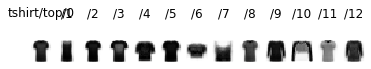

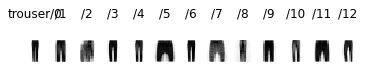

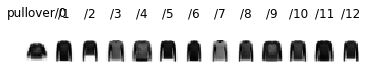

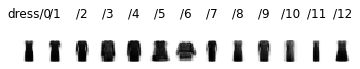

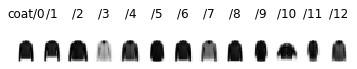

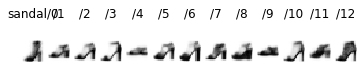

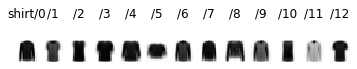

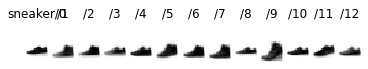

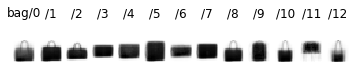

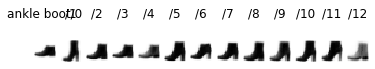

***Training a diagonal GMM with K=15 components***
Label 0: 39 iterations, final MLL     20.260
Label 1: 37 iterations, final MLL     34.220
Label 2: 34 iterations, final MLL     17.662
Label 3: 39 iterations, final MLL     24.001
Label 4: 39 iterations, final MLL     21.691
Label 5: 39 iterations, final MLL     12.409
Label 6: 39 iterations, final MLL     17.258
Label 7: 18 iterations, final MLL     32.972
Label 8: 39 iterations, final MLL      5.298
Label 9: 29 iterations, final MLL     19.737
K=15: acc train 76.79, acc val 75.58


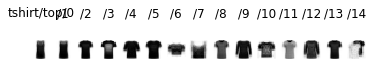

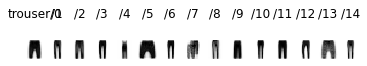

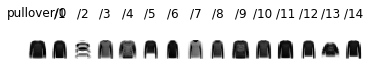

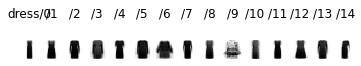

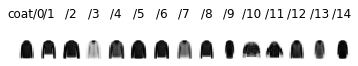

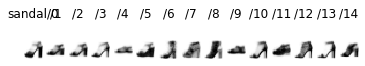

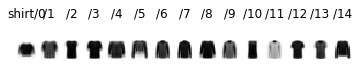

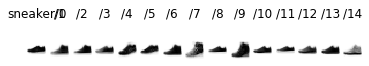

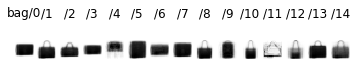

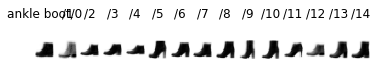

***Training a diagonal GMM with K=17 components***
Label 0: 17 iterations, final MLL     21.116
Label 1: 39 iterations, final MLL     34.652
Label 2: 39 iterations, final MLL     18.056
Label 3: 39 iterations, final MLL     24.756
Label 4: 39 iterations, final MLL     22.397
Label 5: 39 iterations, final MLL     12.920
Label 6: 39 iterations, final MLL     18.038
Label 7: 39 iterations, final MLL     32.965
Label 8: 39 iterations, final MLL      6.804
Label 9: 39 iterations, final MLL     20.574
K=17: acc train 77.31, acc val 76.29


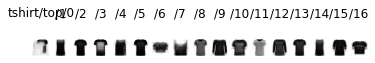

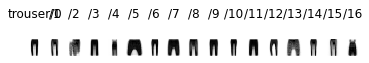

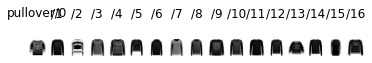

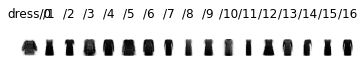

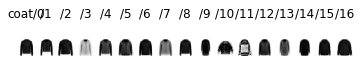

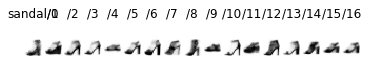

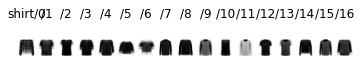

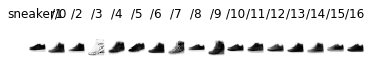

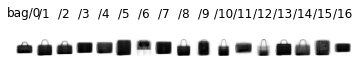

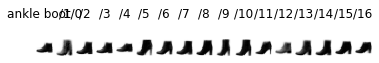

***Training a diagonal GMM with K=19 components***
Label 0: 39 iterations, final MLL     21.565
Label 1: 39 iterations, final MLL     35.010
Label 2: 39 iterations, final MLL     18.646
Label 3: 27 iterations, final MLL     25.218
Label 4: 29 iterations, final MLL     22.951
Label 5: 39 iterations, final MLL     13.404
Label 6: 39 iterations, final MLL     18.588
Label 7:  7 iterations, final MLL     33.677
Label 8: 39 iterations, final MLL      7.591
Label 9: 39 iterations, final MLL     21.127
K=19: acc train 76.87, acc val 75.19


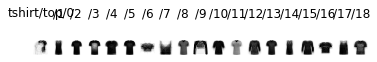

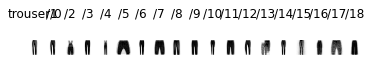

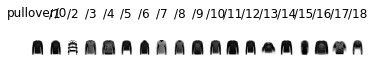

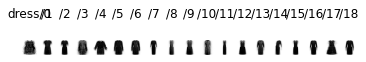

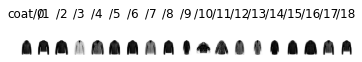

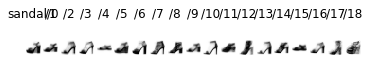

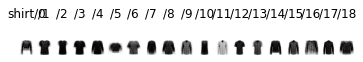

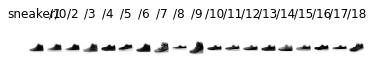

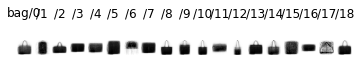

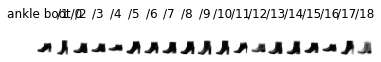

***Training a diagonal GMM with K=21 components***
Label 0: 39 iterations, final MLL     22.128
Label 1: 39 iterations, final MLL     35.546
Label 2: 39 iterations, final MLL     19.669
Label 3: 39 iterations, final MLL     25.740
Label 4: 24 iterations, final MLL     23.242
Label 5: 39 iterations, final MLL     14.051
Label 6: 37 iterations, final MLL     19.156
Label 7: 35 iterations, final MLL     33.820
Label 8: 39 iterations, final MLL      8.077
Label 9: 39 iterations, final MLL     21.598
K=21: acc train 78.22, acc val 76.73


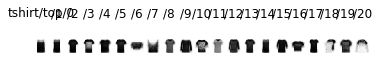

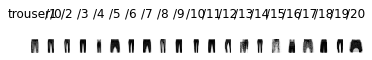

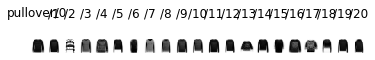

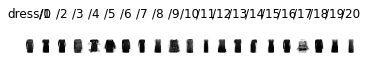

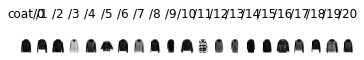

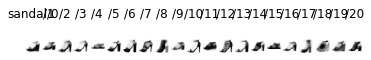

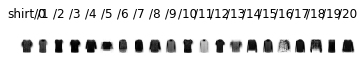

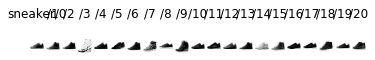

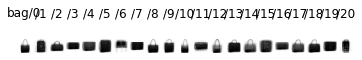

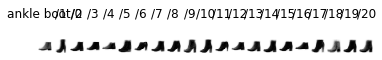

***Training a diagonal GMM with K=25 components***
Label 0: 19 iterations, final MLL     22.895
Label 1: 39 iterations, final MLL     36.176
Label 2: 39 iterations, final MLL     20.681
Label 3: 39 iterations, final MLL     26.335
Label 4: 39 iterations, final MLL     24.050
Label 5: 39 iterations, final MLL     14.565
Label 6: 39 iterations, final MLL     19.937
Label 7: 28 iterations, final MLL     34.391
Label 8: 24 iterations, final MLL      9.090
Label 9: 33 iterations, final MLL     22.650
K=25: acc train 78.75, acc val 76.94


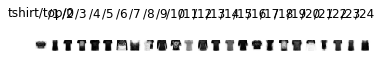

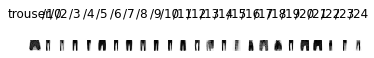

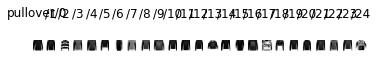

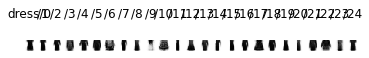

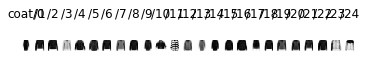

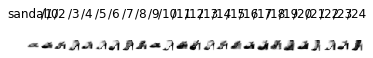

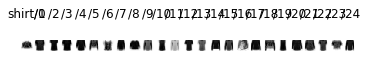

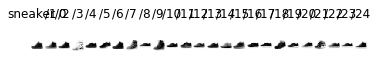

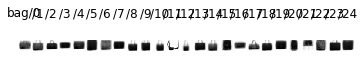

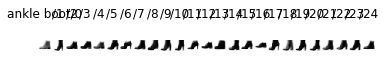

***Training a diagonal GMM with K=27 components***
Label 0: 39 iterations, final MLL     23.282
Label 1: 39 iterations, final MLL     36.588
Label 2: 36 iterations, final MLL     20.859
Label 3: 13 iterations, final MLL     26.778
Label 4: 17 iterations, final MLL     24.562
Label 5: 39 iterations, final MLL     15.091
Label 6: 39 iterations, final MLL     20.235
Label 7: 23 iterations, final MLL     34.533
Label 8: 29 iterations, final MLL      9.913
Label 9: 39 iterations, final MLL     22.758
K=27: acc train 79.48, acc val 77.87


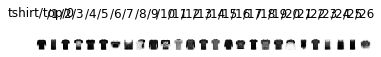

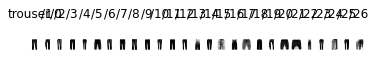

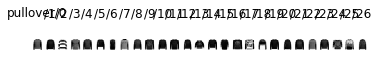

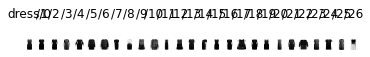

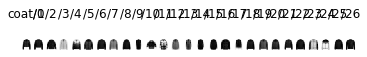

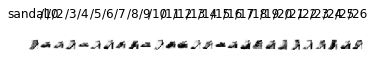

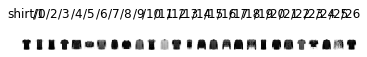

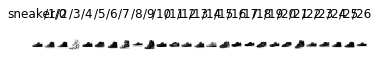

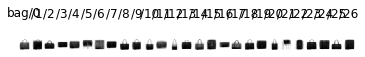

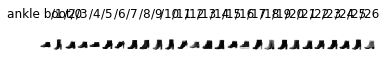

***Training a diagonal GMM with K=29 components***
Label 0: 39 iterations, final MLL     23.698
Label 1: 39 iterations, final MLL     37.128
Label 2: 37 iterations, final MLL     21.091
Label 3: 39 iterations, final MLL     26.862
Label 4: 39 iterations, final MLL     25.142
Label 5: 39 iterations, final MLL     16.152
Label 6: 29 iterations, final MLL     20.527
Label 7: 26 iterations, final MLL     34.722
Label 8: 29 iterations, final MLL     10.087
Label 9: 39 iterations, final MLL     23.105
K=29: acc train 80.25, acc val 78.41


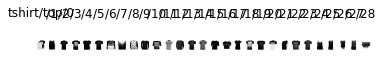

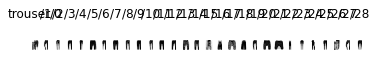

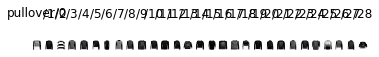

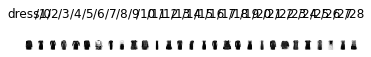

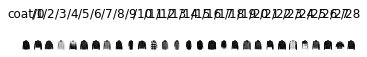

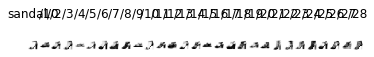

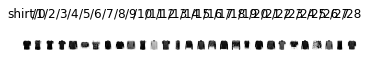

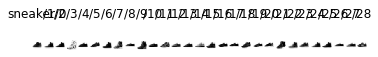

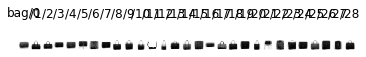

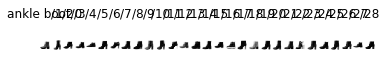

In [ ]:
set_seed(0)
smoothing = 0.1
for num_components in [1, 3, 5, 7, 9, 11,13,15,17,19,21,25,27,29]:
  print('***Training a diagonal GMM with K={:d} components***'.format(num_components))
  models = []
  for y in range(data_train.num_labels):
    model = GMM(data_train.dim, num_components, diag=True)
    trainer = GMMTrainerEM(model, smoothing=smoothing)
    models.append(model)
    mll, iteration = trainer.train(data_train.partition[y], num_iterations_max=40, verbose=False)
    print('Label {:d}: {:2d} iterations, final MLL {:10.3f}'.format(y, iteration, mll))
  acc_train, _ = compute_accuracy(models, data_train)
  acc_val, _ = compute_accuracy(models, data_val)
  print('K={:d}: acc train {:3.2f}, acc val {:3.2f}'.format(num_components, acc_train, acc_val))
  for y in range(10):
    show_means(models, y)
    plt.show()

## <font color=red>Question</font>
For GMMs with diagonal covariance matrices, report
- $K=1$: train acc, val acc
- $K=3$: train acc, val acc

## <font color=red>Answer</font>
- $K=1$: Train: 65.01, Val: 64.29
- $K=3$: Train: 71.21, Val: 70.92

# Experiments with Full-Covariance GMMs

Similarly we will train full-covariance GMMs for various $K$ values. Again, the training is pretty sensitive to the smoothing parameter. In fact, the marginal log-likelihood may take positive values (invalid!!!) due to numerical instability, but we can still do classification with the model.

***Training a full-covariance GMM with K=1 components***
Label 0:  1 iterations, final MLL  -4873.000
Label 1:  1 iterations, final MLL  -2470.271
Label 2:  1 iterations, final MLL  -5623.915
Label 3:  1 iterations, final MLL  -3928.172
Label 4:  1 iterations, final MLL  -4885.274
Label 5:  1 iterations, final MLL  -4377.308
Label 6:  1 iterations, final MLL  -5876.185
Label 7:  1 iterations, final MLL  -2426.176
Label 8:  1 iterations, final MLL  -7732.448
Label 9:  1 iterations, final MLL  -4738.869
K=1: acc train 67.77, acc val 67.36


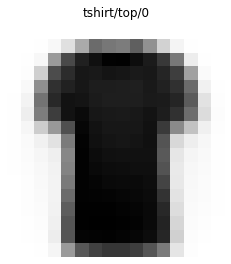

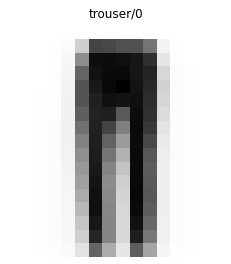

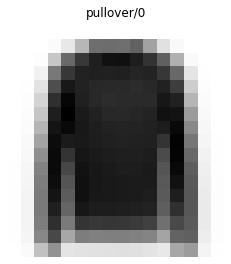

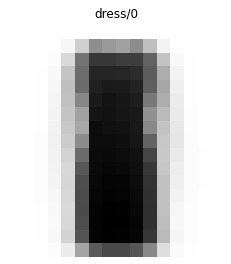

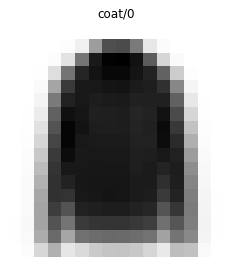

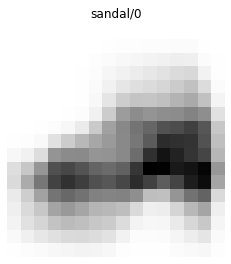

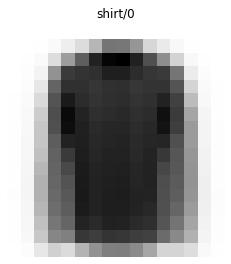

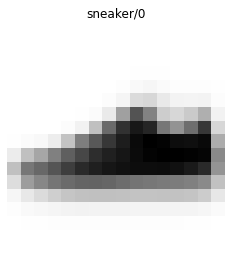

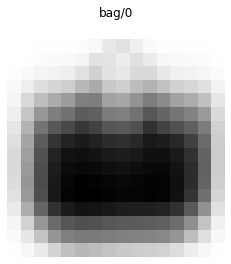

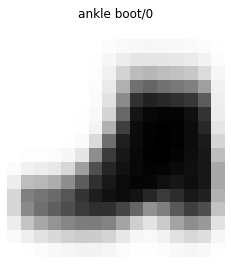

***Training a full-covariance GMM with K=3 components***
Label 0: 12 iterations, final MLL  -2543.119
Label 1: 15 iterations, final MLL  -1507.845
Label 2: 12 iterations, final MLL  -2889.448
Label 3: 16 iterations, final MLL  -2322.440
Label 4: 22 iterations, final MLL  -2762.227
Label 5: 17 iterations, final MLL  -3186.275
Label 6:  6 iterations, final MLL  -2981.758
Label 7: 26 iterations, final MLL  -1489.249
Label 8: 19 iterations, final MLL  -4742.273
Label 9: 10 iterations, final MLL  -2847.575
K=3: acc train 73.62, acc val 73.14


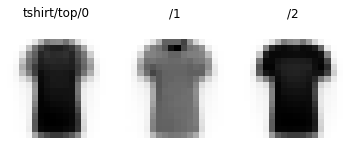

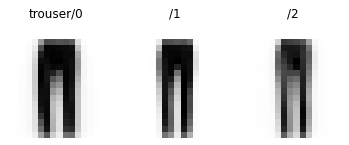

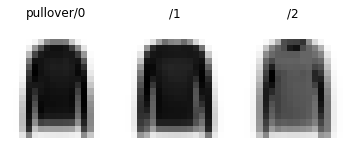

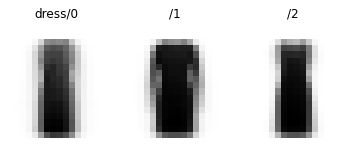

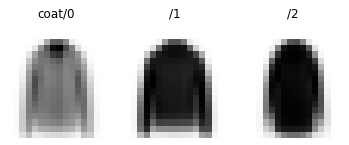

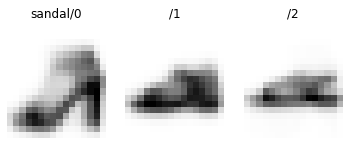

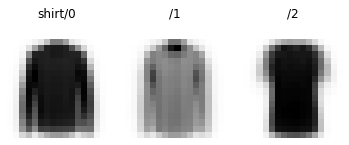

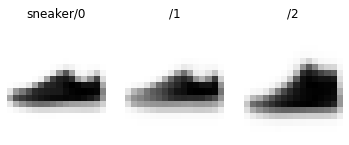

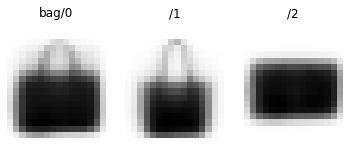

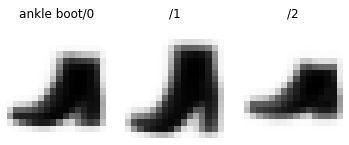

***Training a full-covariance GMM with K=5 components***
Label 0: 26 iterations, final MLL  -2103.545
Label 1: 30 iterations, final MLL  -1133.928
Label 2: 29 iterations, final MLL  -2363.877
Label 3: 28 iterations, final MLL  -1961.296
Label 4: 19 iterations, final MLL  -2213.081
Label 5:  8 iterations, final MLL  -2787.670
Label 6: 12 iterations, final MLL  -2520.063
Label 7: 38 iterations, final MLL  -1190.238
Label 8: 19 iterations, final MLL  -4048.558
Label 9: 38 iterations, final MLL  -2443.419
K=5: acc train 75.87, acc val 74.89


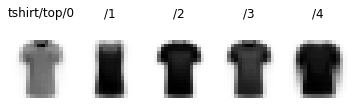

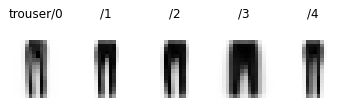

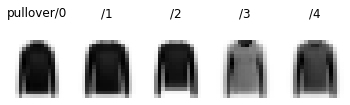

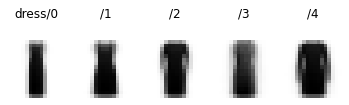

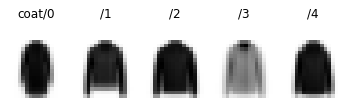

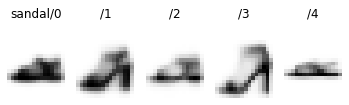

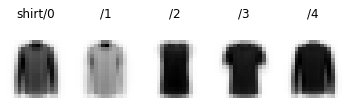

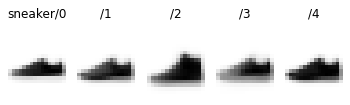

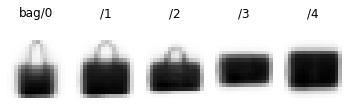

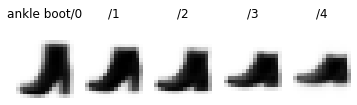

***Training a full-covariance GMM with K=7 components***
Label 0: 21 iterations, final MLL  -1876.813
Label 1: 15 iterations, final MLL   -996.724
Label 2: 39 iterations, final MLL  -2137.015
Label 3: 38 iterations, final MLL  -1749.213
Label 4: 23 iterations, final MLL  -1940.466
Label 5: 28 iterations, final MLL  -2554.051
Label 6: 19 iterations, final MLL  -2195.140
Label 7: 16 iterations, final MLL  -1035.594
Label 8: 37 iterations, final MLL  -3412.827
Label 9: 31 iterations, final MLL  -2156.500
K=7: acc train 76.87, acc val 76.53


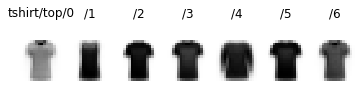

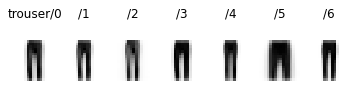

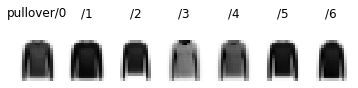

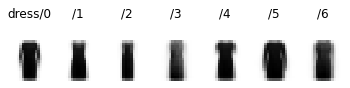

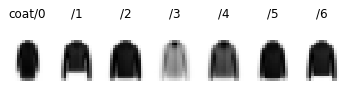

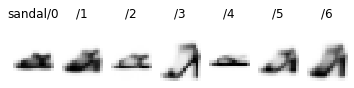

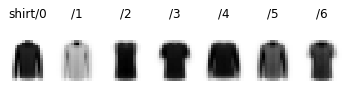

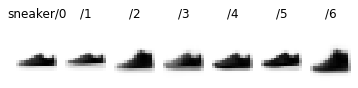

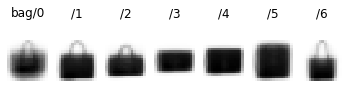

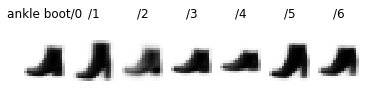

***Training a full-covariance GMM with K=9 components***
Label 0: 39 iterations, final MLL  -1768.520
Label 1: 39 iterations, final MLL   -858.493
Label 2: 39 iterations, final MLL  -1954.754
Label 3: 32 iterations, final MLL  -1599.959
Label 4: 39 iterations, final MLL  -1780.077
Label 5: 39 iterations, final MLL  -2411.858
Label 6: 39 iterations, final MLL  -2020.001
Label 7: 17 iterations, final MLL   -941.792
Label 8: 26 iterations, final MLL  -3119.677
Label 9: 36 iterations, final MLL  -1996.012
K=9: acc train 78.49, acc val 77.80


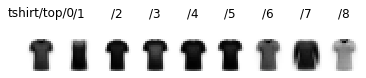

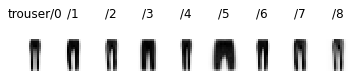

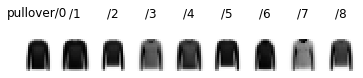

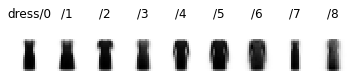

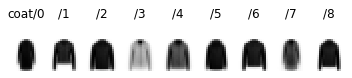

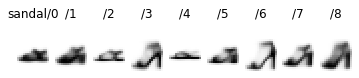

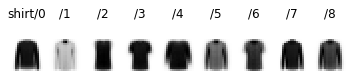

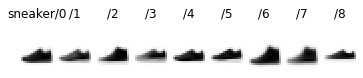

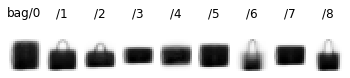

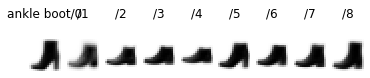

***Training a full-covariance GMM with K=11 components***
Label 0: 39 iterations, final MLL  -1684.034
Label 1: 39 iterations, final MLL   -780.580
Label 2: 24 iterations, final MLL  -1860.373
Label 3: 39 iterations, final MLL  -1507.152
Label 4: 39 iterations, final MLL  -1660.902
Label 5: 34 iterations, final MLL  -2322.120
Label 6: 33 iterations, final MLL  -1937.938
Label 7: 39 iterations, final MLL   -870.060
Label 8: 28 iterations, final MLL  -2911.567
Label 9: 27 iterations, final MLL  -1875.736
K=11: acc train 78.62, acc val 77.33


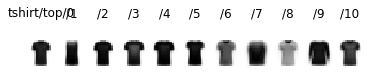

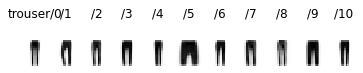

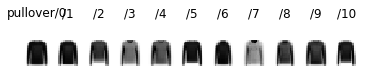

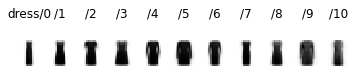

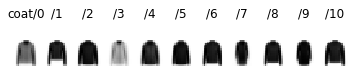

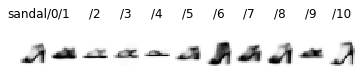

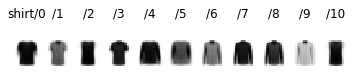

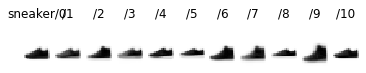

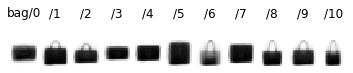

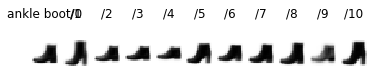

***Training a full-covariance GMM with K=13 components***
Label 0: 37 iterations, final MLL  -1617.806
Label 1: 39 iterations, final MLL   -727.746
Label 2: 39 iterations, final MLL  -1765.228
Label 3: 26 iterations, final MLL  -1445.911
Label 4: 39 iterations, final MLL  -1558.870
Label 5: 28 iterations, final MLL  -2263.634
Label 6: 32 iterations, final MLL  -1832.877
Label 7: 39 iterations, final MLL   -818.271
Label 8: 39 iterations, final MLL  -2761.013
Label 9: 39 iterations, final MLL  -1786.494
K=13: acc train 80.34, acc val 78.83


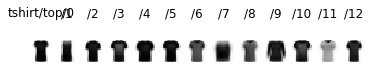

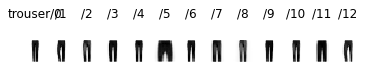

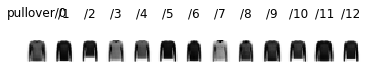

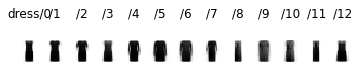

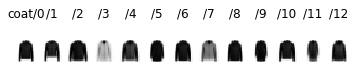

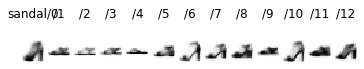

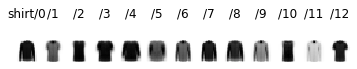

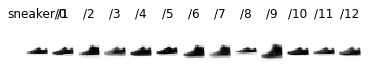

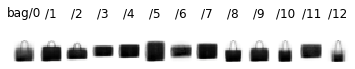

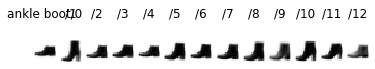

***Training a full-covariance GMM with K=15 components***
Label 0: 39 iterations, final MLL  -1541.347
Label 1: 32 iterations, final MLL   -663.982
Label 2: 30 iterations, final MLL  -1691.481
Label 3: 25 iterations, final MLL  -1389.505
Label 4: 28 iterations, final MLL  -1494.692
Label 5: 39 iterations, final MLL  -2212.991
Label 6: 39 iterations, final MLL  -1750.827
Label 7: 39 iterations, final MLL   -778.267
Label 8: 26 iterations, final MLL  -2672.123
Label 9: 39 iterations, final MLL  -1718.305
K=15: acc train 80.39, acc val 78.63


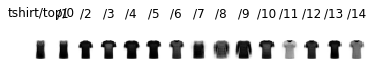

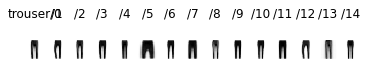

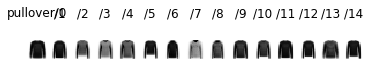

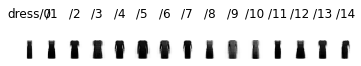

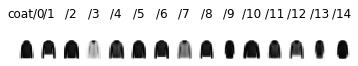

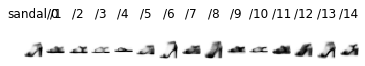

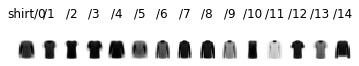

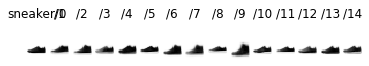

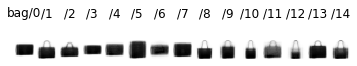

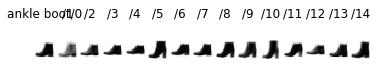

***Training a full-covariance GMM with K=17 components***
Label 0: 39 iterations, final MLL  -1489.609
Label 1: 39 iterations, final MLL   -622.043
Label 2: 39 iterations, final MLL  -1657.790
Label 3: 34 iterations, final MLL  -1328.875
Label 4: 24 iterations, final MLL  -1453.752
Label 5: 39 iterations, final MLL  -2146.135
Label 6: 39 iterations, final MLL  -1685.262
Label 7: 28 iterations, final MLL   -744.231
Label 8: 25 iterations, final MLL  -2596.810
Label 9: 39 iterations, final MLL  -1672.850
K=17: acc train 80.60, acc val 79.18


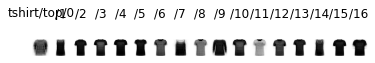

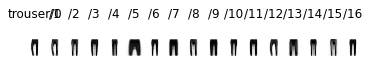

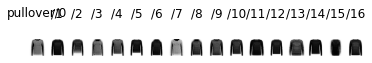

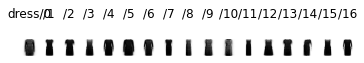

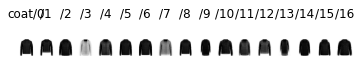

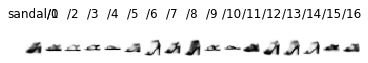

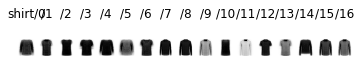

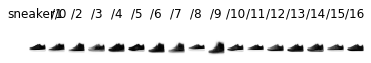

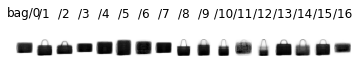

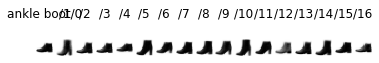

***Training a full-covariance GMM with K=19 components***
Label 0: 39 iterations, final MLL  -1445.635
Label 1: 39 iterations, final MLL   -579.748
Label 2: 39 iterations, final MLL  -1578.291
Label 3: 33 iterations, final MLL  -1277.950
Label 4: 39 iterations, final MLL  -1377.954
Label 5: 39 iterations, final MLL  -2092.522
Label 6: 39 iterations, final MLL  -1625.116
Label 7: 39 iterations, final MLL   -715.740
Label 8: 39 iterations, final MLL  -2520.930
Label 9: 39 iterations, final MLL  -1601.972
K=19: acc train 80.93, acc val 78.98


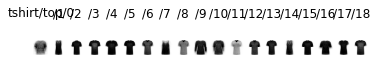

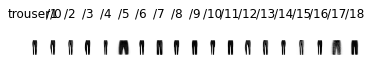

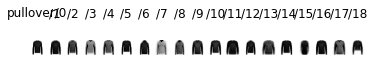

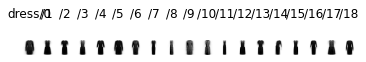

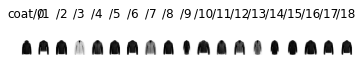

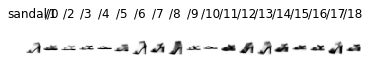

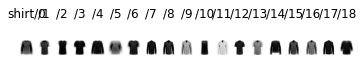

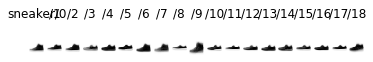

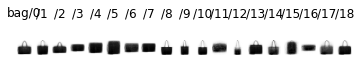

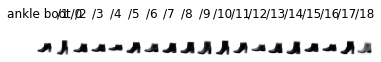

In [ ]:
set_seed(0)
smoothing = 0.001
for num_components in [1, 3, 5, 7, 9, 11, 13,15,17,19]:
  print('***Training a full-covariance GMM with K={:d} components***'.format(num_components))
  models = []
  for y in range(data_train.num_labels):
    model = GMM(data_train.dim, num_components, diag=False)
    trainer = GMMTrainerEM(model, smoothing=smoothing)
    models.append(model)
    mll, iteration = trainer.train(data_train.partition[y], num_iterations_max=40, verbose=False)
    print('Label {:d}: {:2d} iterations, final MLL {:10.3f}'.format(y, iteration, mll))
  acc_train, _ = compute_accuracy(models, data_train)
  acc_val, _ = compute_accuracy(models, data_val)
  print('K={:d}: acc train {:3.2f}, acc val {:3.2f}'.format(num_components, acc_train, acc_val))
  for y in range(10):
    show_means(models, y)
    plt.show()

## <font color=red>Question</font>
For GMMs with full covariance matrices, report
- $K=1$: train acc, val acc
- $K=3$: train acc, val acc

## <font color=red>Answer</font>
- $K=1$: train acc: 67.77, val acc: 67.36
- $K=3$: train acc: 73.62, val acc: 73.14


---

## <font color=red>Question</font>
Explore the model space with different settings: varying number of components across classes (required), covariance matrix restrictions (required), initialization of GMM, convergence criteria of training, etc
- Report the setting and val accuracy of your single **best model**.
- Describe (in detail) the **trend in accuracies** (train and val) across settings
- Describe (in detail) the **trend in visualized cluster** (displayed by the showMeans function) across settings


## <font color=red>Answer</font>
- **Best Model**: K = 19 with full covariance marix. Train acc: 80.93, Val acc: 78.98

- The train and val accuracies increased at good rate till k = 19 in full covarince matrix but after that computation time increased dastically and the improvements in performace was not that good. 

- With more and more components the image got clearer and it included more variations of an a single clothing item. This improved the accuracy since there were more variations included, the model could classify better in the validation set